<a href="https://colab.research.google.com/github/dltnqls9788/convolutional-neural-network/blob/main/ResNet50_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

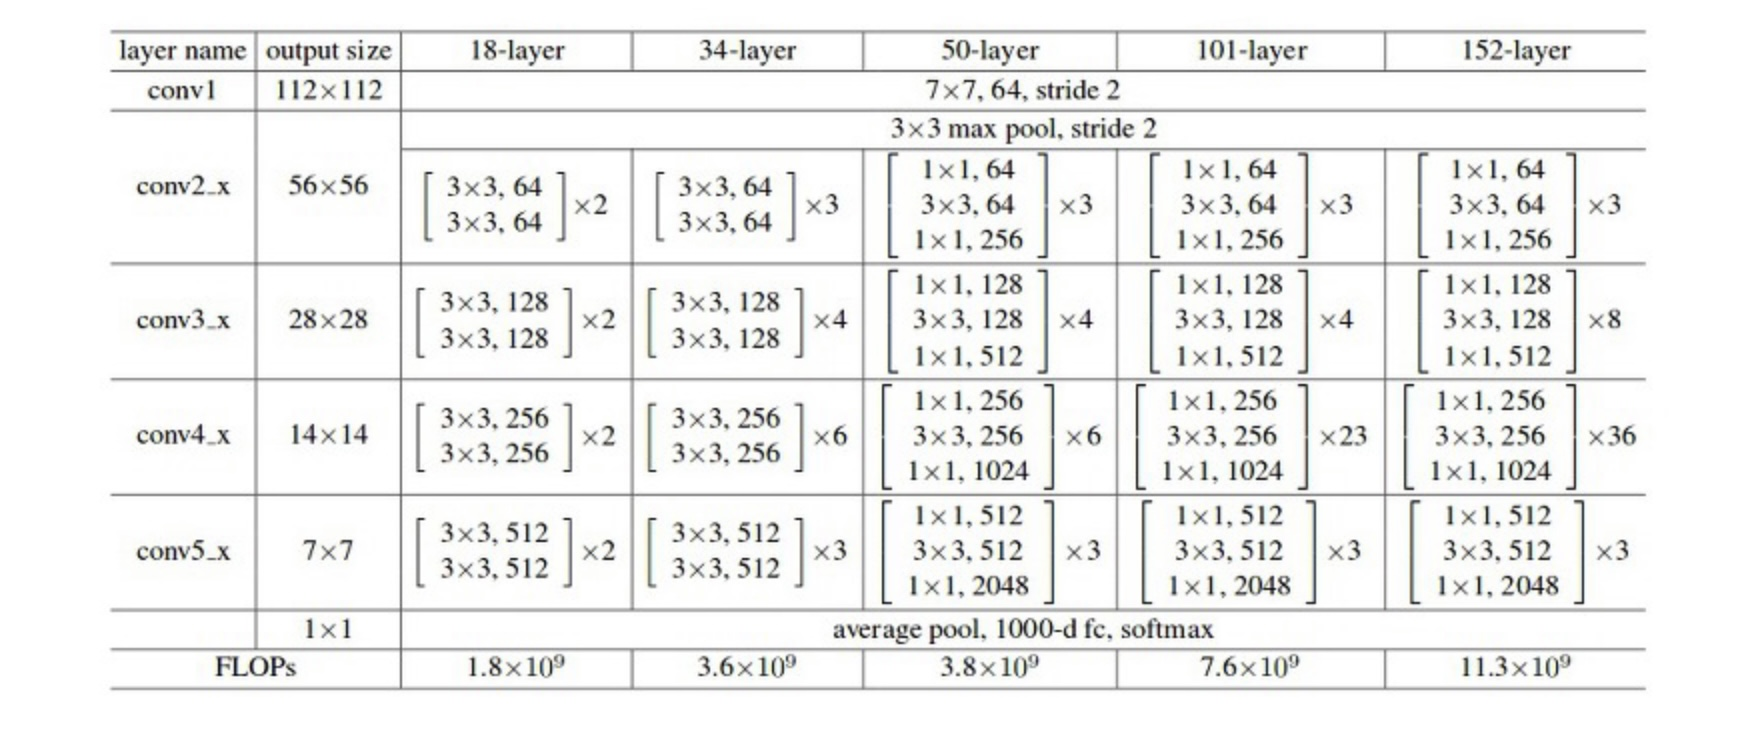

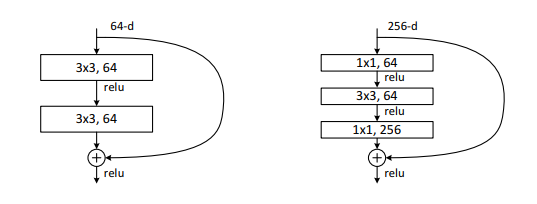

ResNet50 이상인 버전에서는 bottleneck skip connection 구조 사용

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
resnet = ResNet50(weights='imagenet')
resnet.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
json_string = resnet.to_json()

with open("model.json", "w") as f:
  f.write(json_string)

In [ ]:
from keras import model, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

import os 
import matplotlib.pyplot as plt 
import numpy as np
import math 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join('./train')
val_dir = os.path.join('./val')

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224,224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224,224), color_mode='rgb')

# number of classes
num_classes = 4 

input_tensor = Input(shape=(224,224,3), dtype='float32', name='input')

### Conv1

In [ ]:
def conv1_layer(x):
    x = ZeroPadding2D(padding=(3,3))(x)
    x = Conv2D(64, (7,7), strides=(2,2))(x)
    x = BatchNormalization(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x 

### Conv2

In [ ]:
def conv2_layer(x):
    x = MaxPooling2D((3,3),2)(x)

    shortcut = x
    
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x) # valid : padding 안함
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64 (3,3), strides=(1,1), padding='same')(x) # same : 입력과 출력 같게 패딩 적용
            x = BatchNormalization()(x)
            x = Activation('relu')(x)


            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(256, (1,1), strides=(1,1), padding='valid')(shortcut) 

            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else: 
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x 

      return x 

### Conv3

In [ ]:
def conv3_layer(x):

    shortcut = x

    for i in range(4):
        if (i == 0):
          x = Conv2D(128, (1,1), strides=(2,2), padding='valid')(x)
          x = BatchNormalization(x)
          x = Activation('relu')(x)

          x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
          x = BatchNormalization(x)
          x = Activation('relu')(x)

          x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
          shortcut = Conv2D(512, (1,1), strides=(2,2), padding='valid')(shortcut)
          x = BatchNormalization(x)
          shortcut = BatchNormalization(shortcut)

          x = Add()([x, shortcut])
          x = Activation('relu')(x)

          shortcut = x 

        else:
          x = Conv2D(128, (1,1), strides=(1,1), padding='valid')(x)
          x = BatchNormalization(x)
          x = Activation('relu')(x)

          x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
          x = BatchNormalization(x)
          x = Activation('relu')(x)

          x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
          x = BatchNormalization(x)

          x = Add()([x, shortcut])
          x = Activation('relu')(x)

          shortcut = x

    retrun x 

### Conv4

In [ ]:
def conv4_layer(x):

    shortcut = x 

    for i in range(6):
      if (i == 0):
        x = Conv2D(256, (1,1), strides=(2,2), padding='valid')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(1024, (1,1), strides=(1,1), padding='valid')(x)
        shortcut = Conv2D(1024, (1,1), strides=(2,2), padding='valid')(shortcut)
        
        x = BatchNormalization(x)
        shortcut = BatchNormalization(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x

      else :
        x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(1024, (1,1), strides=(1,1), padding='valid')(x)
        x = BatchNormalization(x)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x

    return x 

### Conv5

In [ ]:
def conv5_layer(x):

    shortcut = x 

    for i in range(3):
      if (i == 0):
        x = Conv2D(512, (1,1), strides=(2,2), padding='valid')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(2048, (1,1), strides=(1,1), padding='valid')(x)
        shortcut = Conv2D(2048, (1,1), strides=(2,2), padding='valid')(shortcut)

        x = BatchNormalization(x)
        shortcut = BatchNormalization(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x 

      else:
        x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(x)
        x = Activation('relu')(x)

        x = Conv2D(2048, (1,1), strides=(1,1), padding='valid')(x)
        x = BatchNormalization(x)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x

    return x 

In [ ]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()